# Notebook 022: Build Model Features

This notebook combines features from the cleansed crime incidents dataset as well as a number of other datasets to append each crime incident record with the additional engineered features used in our analysis

In [27]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_crime = os.path.join(FEATURES_ROOT, 'crime-records-for-model-no-features-added.csv')
readfile_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')
readfile_weather = os.path.join(FEATURES_ROOT, 'boston-daily-weather-20140101-20190831.csv')
readfile_streetlights = os.path.join(READDIR_ROOT, 'boston/streetlights.csv')
# readfile_demographics = 
# readfile_colleges = 
# readfile_schools = 
# readfile_violations = 

readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(READDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_property, readfile_weather, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/crime-records-for-model-no-features-added.csv
	../data/processed/property-assessment-features-2013-2019.csv
	../data/processed/boston-daily-weather-20140101-20190831.csv


## Read in datasources for merging

In [3]:
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_property = pd.read_csv(readfile_property, dtype={'shape-id': str, 'fiscal-year': int})
df_weather = pd.read_csv(readfile_weather)
df_lights = pd.read_csv(readfile_streetlights)

df_crime['lat'] = df_crime['lat'].astype(float)
df_crime['lon'] = df_crime['lon'].astype(float)

In [4]:
# print info for each dataframe
print('CRIME DATAFRAME\n')
df_crime.info()
display(df_crime.head())
print('\n\nPROPERTY ASSESSMENT FEATURES DATAFRAME\n')
df_property.info()
display(df_property.head())
print('\n\nWEATHER FEATURES DATAFRAME\n')
df_weather.info()
display(df_weather.head())

CRIME DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 18 columns):
crime-type             151072 non-null object
INCIDENT_NUMBER        151072 non-null object
OFFENSE_DESCRIPTION    151072 non-null object
timestamp              151072 non-null object
lat                    151072 non-null float64
lon                    151072 non-null float64
year                   151072 non-null object
month                  151072 non-null object
day-of-week            151072 non-null object
hour                   151072 non-null object
ZIP5                   151044 non-null object
ZIP5_area              151044 non-null object
Name                   151002 non-null object
Neighborhood_area      151002 non-null object
Neighborhood_area_2    151002 non-null object
TRACTCE10              151072 non-null object
TRACTCE10_area         151072 non-null object
TRACTCE10_area_2       151072 non-null object
dtypes: float64(2), object(16)
memory usag

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,ZIP5,ZIP5_area,Name,Neighborhood_area,Neighborhood_area_2,TRACTCE10,TRACTCE10_area,TRACTCE10_area_2
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,02130,105221153.02392578,Roxbury,91844545.97481573,3.29,980300,22640579.7627,3847996.3515625
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,02135,78620825.92480469,Brighton,80167877.560494,2.88,000202,6475526.5708,1102312.71484375
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,02210,32373210.07080078,South Boston Waterfront,27087395.391558826,0.97,060600,20379799.0356,3468813.69921875
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,02127,67536142.7421875,South Boston,62721306.143917084,2.25,060700,1380119.5437,234830.15234375
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,02119,44511498.52441406,Roxbury,91844545.97481573,3.29,080100,11047170.5891,1879154.8203125




PROPERTY ASSESSMENT FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 5 columns):
shape-id       13002 non-null object
fiscal-year    13002 non-null int64
value          12927 non-null float64
shape-type     13002 non-null object
metric         13002 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 508.0+ KB


,shape-id,fiscal-year,value,shape-type,metric
0,00000,2013,37000.0,zipcode,residential-median-value
1,02026,2013,NaN,zipcode,residential-median-value
2,02108,2013,691300.0,zipcode,residential-median-value
3,02109,2013,456950.0,zipcode,residential-median-value
4,02110,2013,566512.5,zipcode,residential-median-value




WEATHER FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 13 columns):
date            1339 non-null object
weathercodes    660 non-null object
sunrise         1339 non-null int64
sunset          1339 non-null int64
tempavg         1339 non-null float64
tempmax         1339 non-null float64
tempmin         1339 non-null float64
humavg          1338 non-null float64
windavg         1339 non-null float64
windsustain     1339 non-null int64
windmax         1339 non-null int64
precip          1339 non-null float64
snowfall        1339 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 136.1+ KB


,date,weathercodes,sunrise,sunset,tempavg,tempmax,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall
0,2016-01-01,NaN,713,1622,2.8,5.0,0.6,58.0,12.7,23,32,0.0,0.0
1,2016-01-02,NaN,714,1623,2.2,4.4,-0.6,53.0,13.3,22,28,0.0,0.0
2,2016-01-03,NaN,714,1624,3.3,6.7,-0.6,57.0,11.7,21,28,0.0,0.0
3,2016-01-04,SN,714,1625,-3.9,2.2,-10.0,59.0,12.4,21,28,0.0,0.0
4,2016-01-05,NaN,714,1626,-8.3,-3.3,-13.3,41.0,10.0,18,23,0.0,0.0


## Merge property assessment features

In [5]:
# subset property features data to contain only census-tract level metrics
df_property = df_property.loc[df_property['shape-type']=='census tract']
df_property.shape

(9570, 5)

In [6]:
# make list of metrics for matching
print(df_property['metric'].value_counts())

prop_metrics_list = list(df_property['metric'].value_counts().index)

print()
print(prop_metrics_list)

commercial-mix-ratio                 1267
industrial-mix-ratio                 1267
owner-occupied-ratio                 1190
residential-gini-coef                1183
residential-median-value             1183
industrial-mix-ratio-3yr-cagr         724
commercial-mix-ratio-3yr-cagr         724
owner-occupied-ratio-3yr-cagr         680
residential-median-value-3yr-cagr     676
residential-gini-coef-3yr-cagr        676
Name: metric, dtype: int64

['commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-gini-coef', 'residential-median-value', 'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr']


In [7]:
# create temporary match-key column for crime dataset record matching
df_crime['tract-match-key'] = (df_crime['TRACTCE10'].astype(str) + df_crime['year'].astype(str)).values

df_crime['tract-match-key'].head()

0    9803002019
1    0002022019
2    0606002019
3    0607002019
4    0801002019
Name: tract-match-key, dtype: object

In [8]:
# Start list of "temporary match" column names for dropping before saving final dataframe

temp_drop_list = ['tract-match-key']

In [9]:
# create equivalent match-key column for property metrics dataframe
df_property['shape_match'] = (df_property['shape-id'].astype(str) + df_property['fiscal-year'].astype(str)).values
df_property.head()

,shape-id,fiscal-year,value,shape-type,metric,shape_match
420,000100,2013,402150.0,census tract,residential-median-value,0001002013
421,000201,2013,444900.0,census tract,residential-median-value,0002012013
422,000202,2013,447581.0,census tract,residential-median-value,0002022013
423,000301,2013,412700.0,census tract,residential-median-value,0003012013
424,000302,2013,326650.0,census tract,residential-median-value,0003022013


In [10]:
############################################
# Merge property features to crime dataframe
############################################

for metric in prop_metrics_list:
    temp_match_dict = dict(
        zip(
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,1],
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,0]
        )
    )
    df_crime[metric] = df_crime['tract-match-key'].copy().map(temp_match_dict)

In [11]:
# view resulting dataframe with added property features
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 29 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,commercial-mix-ratio,industrial-mix-ratio,owner-occupied-ratio,residential-gini-coef,residential-median-value,industrial-mix-ratio-3yr-cagr,commercial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000000,0.000294,0.000000,0.000000,756500.0,-0.034814,0.000000,0.000000,0.024264,0.000000
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.069416,0.000000,0.550355,0.199606,745950.0,0.000000,-0.010424,-0.028224,0.068142,0.011166
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.478130,0.000938,0.456287,0.228793,538500.0,-0.084828,0.010549,-0.014131,0.060340,0.018436
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.375058,0.076862,0.460751,0.172898,355500.0,0.060168,-0.007779,-0.023444,0.082123,0.025972


## Merge weather data features

In [12]:
# create temporary date match column and add to drop list
temp_drop_list = temp_drop_list + ['date']

df_crime['date'] = df_crime['timestamp'].str[:10]

In [13]:
# create list of weather-related column names for later manipulation
weather_match_cols = df_weather.columns

weather_match_cols

Index(['date', 'weathercodes', 'sunrise', 'sunset', 'tempavg', 'tempmax',
       'tempmin', 'humavg', 'windavg', 'windsustain', 'windmax', 'precip',
       'snowfall'],
      dtype='object')

In [14]:
# merge weather values to crime data 
df_crime = df_crime.merge(df_weather, how='left', on='date')

# print results
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 42 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

## Create night time feature using sunrise and sunset data from weather merge

In [15]:
# convert timestamp to datetime data type for ease of use
df_crime['timestamp'] = pd.to_datetime(df_crime['timestamp'])

# create time values for each record in minutes
df_crime['time'] = (df_crime['timestamp'].dt.hour * 60) + df_crime['timestamp'].dt.minute

In [16]:
# create night time indicator feature
df_crime['night'] = (
    (df_crime['time'] < df_crime['sunrise']) | (df_crime['time'] > df_crime['sunset'])
).astype(int)

In [17]:
# check results
df_crime[['timestamp', 'year', 'month', 'hour', 'time', 'sunrise', 'sunset', 'night']].head()

,timestamp,year,month,hour,time,sunrise,sunset,night
0,2019-08-01 17:46:00,2019,8,17,1066,436,1904,0
1,2019-06-12 21:00:00,2019,6,21,1260,407,1921,0
2,2019-03-10 08:00:00,2019,3,8,480,605,1744,1
3,2019-07-08 10:29:00,2019,7,10,629,415,1923,0
4,2019-04-13 08:00:00,2019,4,8,480,507,1823,1


In [18]:
# add additional columns to drop prior to saving
temp_drop_list = temp_drop_list + ['time', 'sunrise', 'sunset']

## Create streetlight density feature

In [20]:
def distance(locs1, locs2, r=6371, meters=True):
    """
    Converts distances between lat/lon points to meters using the Haversine
    formula for measuring distance on a sphere

    If the desire is to measure pairwise distances between two coordinate
    arrays of equal length, or between two single sets of coordinates, this
    function can simply be called as `distance(locs1, locs2)`

    If the desire is to measure the distances of each coordinate in array 1
    all coordinates in array 2, the function needs to be called in this
    manner `distance(locs1[:, None], locs2)`
    
    locs1: np.array or list of lat/lon points
    locs2: np.array or list of lat/lon points
    r: float, default=6371, great sphere approximated radius of the earth
       in kilometers
    meters: boolean, default=True, specifies the output
            units of the distances returned by this function, meters if True,
            and kilometers if False
    
    returns: np.array of the distances between coordinates in either meters
             or kilometers
    """
    if meters:
        r = r * 1000
    
    # convert lat/lon coordinates to radians
    locs1 = locs1 * np.pi / 180
    locs2 = locs2 * np.pi / 180
    
    cos_lat1 = np.cos(locs1[..., 0])
    cos_lat2 = np.cos(locs2[..., 0])
    
    cos_lat_d = np.cos(locs1[..., 0] - locs2[..., 0])
    cos_lon_d = np.cos(locs1[..., 1] - locs2[..., 1])
    
    a = (1 - cos_lat_d)/2 + cos_lat1 * cos_lat2 * (1 - cos_lon_d)/2
    
    return 2 * r * np.arcsin(np.sqrt(a))

In [22]:
# test distance between widener and boston city hall to confirm
# distance function is working correctly
test_1 = np.array((42.373392, -71.116507))
test_2 = np.array((42.360126, -71.059320))

distance(test_2, test_1)

4924.382348283844

In [24]:
# convert crime locations and streetlight locations to numpy arrays
crime_locs = df_crime[['lat','lon']].values
light_locs = df_lights[['Lat', 'Long']].values

In [30]:
%%time
threshold = 100 # distance in meters
n_splits = 155 # split into batches to prevent memory allocation issues
splits = np.array_split(crime_locs, n_splits)

#calculate streetlight densities, and use tqdm to track progress
for i, split in tqdm(enumerate(splits)):
    distances = distance(split[:, None], light_locs)
    densities = np.sum((distances<100).astype(int), axis=1).reshape(-1,1)
    if i == 0:
        streetlights = densities.copy()
    else:
        streetlights = np.vstack([streetlights.copy(), densities.copy()])


CPU times: user 2min 51s, sys: 42.3 s, total: 3min 33s
Wall time: 3min 33s


(151072, 1)


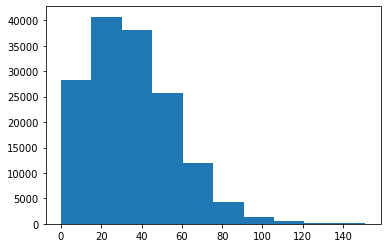

In [33]:
print(streetlights.shape)

plt.hist(streetlights)
plt.show()

In [34]:
# add streetlights feature to crime data
df_crime['streetlights'] = streetlights

In [36]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 45 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall,time,night,streetlights
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,23.3,52.0,7.9,14,20,0.00,0.0,1066,0,7
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,15.6,46.0,11.6,20,23,0.00,0.0,1260,0,8
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,-0.6,83.0,12.8,25,30,0.46,0.9,480,1,26
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,18.9,55.0,7.8,13,15,0.00,0.0,629,0,77
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,13.9,75.0,14.0,24,32,0.28,0.0,480,1,17
